# Modele Seq2Seq i atencja
Poniższy notebook jest inspirowany tym tutorialem PyTorcha: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. Zachęcam żeby zajrzeć tam po więcej informacji.

W tym notebooku będziemy próbować rozwiązać problem automatycznego tłumaczenia zdań z jednego języka naturalnego na drugi -- konkretniej z języka polskiego na angielski. Dla przykładu model otrzymujący zdanie:

> Myślę, że mnie okłamałeś

Powinien zwrócić zdanie
> I think you lied to me.



# Importy i przygotowanie danych
Poniżej znajdują się importy bibliotek potrzebnych do rozwiązania problemu a także skrypt do ładowania zbioru danych zawierającego pary zdań w języku polskim i angielskim. Poniższy kod można odpalić i schować, ale zachęcamy do zaznajomienia się z tym jak wygląda obróbka danych.


In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import string
import numpy as np
import re
import random
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Poniżej przygotowujemy klasę `Lang` która będzie służyła jako struktura do obsługiwania naszego języka (osobna dla angielskiego i polskiego w naszym przypadku). Do każdego słowa w języku przypisujemy indeks (liczbę porządkową identyfikującą słowo). Dodatkowo definiujemy trzy dodatkowe indeksy:

* 0 dla początku zdania (Start of Sentence, SOS)
* 1 dla końca zdania (End of Sentence, EOS)
* 2 dla paddingu ("pustych" wartości). Wartościami tymi będziemy wypełniać zdania w batchu tak, żeby wszystkie były równej długości -- dzięki temu łatwiej będzie zrównoleglić przetwarzanie ich na GPU.

In [3]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3 # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Funkcje do normalizowania wchodzących zdań - zamieniamy Unicode na ASCII, zamieniamy wszystkie wielkie litery na małe itd.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace("ł", "l")
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('eng-pol.txt', encoding='utf-8').\
        read().strip().split('\n')
    lines = lines[1:]  # Skip first line with attributions.

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[1::2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Wyrzućmy zdania które są zbyt długie (ponad 20 słów).

In [5]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH and \
        len(p[1].split(' ')) <= MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Pełny proces przetwarzania danych wygląda następująco:

- Wczytujemy plik z danymi, dzielimy go na pary zdań.
- Normalizujemy tekst
- Zamieniamy zdania w listy słów.




In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(pairs[0])
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('pol', 'eng', True)
print("Przykładowe pary zdań:")
for _ in range(3):
    print(random.choice(pairs))

Reading lines...
['sprobujmy cos .', 'let s try something .']
Read 59749 sentence pairs
Trimmed to 59404 sentence pairs
Counting words...
Counted words:
eng 29246
pol 11953
Przykładowe pary zdań:
['wczoraj bylo cieplo .', 'it was hot yesterday .']
['bylem tam juz .', 'i ve been there before .']
['popelnilem koszmarny blad .', 'i made a nightmarish mistake .']


Na koniec definiujemy jeszcze funkcje, które pozwolą nam zamienić zdania w tensory, które nasza sieć będzie w stanie zrozumieć.

In [7]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def pad_sequences(data_batch):
    pl_batch, en_batch = [], []
    for pl_sentence, en_sentence in data_batch:
        pl_batch += [pl_sentence]
        en_batch += [en_sentence]
    pl_batch = pad_sequence(pl_batch, padding_value=PAD_token, batch_first=True)
    en_batch = pad_sequence(en_batch, padding_value=PAD_token, batch_first=True)
    return pl_batch, en_batch

def prepare_dataset(batch_size):
    rng = np.random.RandomState(567)
    indices = np.arange(len(pairs))
    rng.shuffle(indices)
    train_indices = indices[:int(len(pairs) * 0.8)]
    test_indices = indices[int(len(pairs) * 0.8):]
    train_pairs = list(pairs[idx] for idx in train_indices)
    test_pairs = list(pairs[idx] for idx in test_indices)
    tensor_train_pairs = [tensorsFromPair(pairs[idx]) for idx in train_indices]
    tensor_test_pairs = [tensorsFromPair(pairs[idx]) for idx in test_indices]
    reference_translation = test_pairs

    # Output in natural language?

    train_loader = DataLoader(tensor_train_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    test_loader = DataLoader(tensor_test_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    return train_pairs, test_pairs, train_loader, test_loader

# Model Seq2Seq



W tym celu wykorzystany rekurencyjne sieci neuronowe (RNN-y), które poznaliśmy na poprzednich zajęciach. Konkretniej zbudujemy za ich pomocą model Sequence to Sequence (Seq2Seq), w której wykorzystamy dwie sieci rekurencyjne:
1. Enkoder, który będzie przyjmował kolejno słowa ze zdania wejściowego i kompresował informacje o nich w swoim stanie ukrytym.
2. Dekoder, który będzie generował kolejne słowa w języku docelowym. 

![seq2seq](https://docs.chainer.org/en/stable/_images/seq2seq.png)
Źródło: https://docs.chainer.org/

## Funkcje pomocnicze i ewaluacyjne

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def predict(encoder, decoder, inputs, targets=None, max_len=MAX_LENGTH):
    batch_size = inputs.size(0)

    encoder_outputs, encoder_hidden = encoder(inputs)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device)
    decoder_hidden = encoder_hidden
    decoder_output, decoder_attention = decoder(
        decoder_input,
        decoder_hidden,
        targets=targets,
        max_len=max_len,
        encoder_outputs=encoder_outputs)
    return decoder_output, decoder_attention

def translate(encoder, decoder, sentence, show_attention=True):
    inputs = tensorFromSentence(input_lang, sentence).unsqueeze(0).cuda()
    decoder_output, decoder_attention = predict(encoder, decoder, inputs)

    decoded_words = []
    for word in decoder_output[0]:
        top_word = word.argmax(-1).item()
        decoded_words.append(output_lang.index2word[top_word])
        if top_word == EOS_token:
            break

    if decoder_attention is not None and show_attention:
        # [out_words, in_words]
        att = decoder_attention.cpu().detach().numpy()
        att = att[0, :len(decoded_words), :]
        fig, ax = plt.subplots()

        im = ax.imshow(att, vmin=0, vmax=1)
        ax.xaxis.tick_top()
        ax.set_xticklabels([''] + sentence.split(' ') +
                        ['EOS'], rotation=90)
        ax.set_yticklabels([''] + decoded_words)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)

        fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    return decoded_words

def batch_translate(encoder, decoder, batch):
    decoder_output, decoder_attention = predict(encoder, decoder, batch)

    predicted_sentences = []

    # TODO: potentially paralellize?
    for batch_idx in range(len(batch)):
        predicted_words = []
        for word in decoder_output[batch_idx]:
            top_word = word.argmax(-1).item()
            if top_word == EOS_token:
                break
            predicted_words.append(output_lang.index2word[top_word])

        predicted_sentences.append(predicted_words)

    return predicted_sentences

def dataset_translate(encoder, decoder, loader):
    predicted_sentences = []
    reference_sentences = [] 
    for batch_in, batch_out in loader:
        translated = batch_translate(encoder, decoder, batch_in)
        predicted_sentences.extend(translated)

        # TODO: move to a separate file?
        reference_words = []
        for sentence_idx, sentence in enumerate(batch_out):
            decoded_sentence = []
            for word in sentence:
                if word.item() == EOS_token:
                    break
                decoded_sentence.append(output_lang.index2word[word.item()])
            reference_sentences.append(decoded_sentence)
    
    return predicted_sentences, reference_sentences


def translate_randomly(encoder, decoder, pairs, n=10):
    # TODO: reuse translate_given_pairs
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

def translate_given_pairs(encoder, decoder, pairs):
    for pair in pairs:
        print('>', pair[0])
        print('=', pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def plot_results(bleus, losses):
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    axes[0].plot(np.arange(len(bleus)), bleus)
    axes[0].set_xlabel("Epoka")
    axes[0].set_ylabel("BLEU")
    axes[1].plot(np.arange(len(losses)), losses)
    axes[1].set_xlabel("Epoka")
    axes[1].set_ylabel("Koszt na zbiorze treningowym")

## Pętla trenująca

In [9]:
def train(encoder, decoder, lr=0.01, batch_size=256, teacher_forcing_ratio=0.5, epochs_num=100, clipping=1.0):

    # Prepare dataset, loss functions, optimizer
    train_pairs, test_pairs, train_loader, test_loader = prepare_dataset(batch_size)

    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

    encoder.cuda()
    decoder.cuda()

    bleus = []
    train_losses = []

    for epoch in range(epochs_num + 1):

        # Training
        epoch_train_loss = 0.
        for in_batch, out_batch in train_loader:
            in_batch, out_batch = in_batch.cuda(), out_batch.cuda()

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
        
            teacher_inputs = out_batch if random.random() < teacher_forcing_ratio else None
        
            decoder_output, decoded_attention = predict(
                encoder, decoder, in_batch,
                targets=teacher_inputs,
                max_len=out_batch.size(1)
            )

            loss = criterion(decoder_output.transpose(1, 2), out_batch)
            
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(encoder.parameters(), clipping)
            nn.utils.clip_grad_norm_(decoder.parameters(), clipping)

            encoder_optimizer.step()
            decoder_optimizer.step()

            epoch_train_loss += loss.item()

        # Evaluation
        if epoch % 1 == 0:
            with torch.no_grad():
                print("=" * 25, "Translation test", "=" * 25)
                translate_randomly(encoder, decoder, test_pairs, n=5)

            pred_sentences, ref_sentences = dataset_translate(encoder, decoder, test_loader)
            bleu_val = bleu_score(pred_sentences, [[sentence] for sentence in ref_sentences])
            print("=" * 25, f"BLEU: {bleu_val}", "=" * 25)
            bleus += [bleu_val]

        mean_train_loss = epoch_train_loss / len(train_loader)
        train_losses += [mean_train_loss]
        print(f"Epoch: {epoch}. Train loss: {mean_train_loss}")
    return bleus, train_losses

<h4> Zadanie 1 - Dekoder w Seq2Seq </h4>

W tym zadaniu należy zaimplementować dekoder z modelu Seq2Seq. Kod enkodera jest dostępny poniżej i ma Państwu ułatwić odpowiednie zaimplementowanie dekodera.

Dekoder otrzymuje na wejściu następujące argumenty:
- `input` - tensor o wymiarach `[batch_size, 1]` zawierający słowo `<BOS>`. Powinno być podane w pierwszym kroku wykonywania dekodera.
- `hidden` - ostatnia reprezentacja ukryta z enkodera .
- `targets` - `None` albo `torch.tensor` o wymiarach `[batch_size, seq_len]` zawierający indeksy słów w języku docelowym. Jeżeli jest podany to należy zaimplementować teacher forcing na jego podstawie.
- `max_len` - Długość sekwencji, którą mamy zwrócić.
- `encoder_outputs` - w tym zadaniu ten argument należy zignorować, przyda się dopiero w kolejnym zadaniu.

Dekoder ma zwrócić dwie zmienne:
- `output` - tensor o wymiarach `[batch_size, max_len, vocab_size]` reprezentujące logity, które po zaaplikowaniu softmaksa (co będzie zrobione już poza dekoderem) będą reprezentowały prawdopodobieństwa słów przewidzianych przez nasz dekoder.
- `attention_weights` - w tym zadaniu należy zawsze zwracać `None`.

Architektura głowy klasyfikacyjnej jest dowolna, natomiast zalecamy sieć z jedną warstwą ukrytą: `[hidden_size, hidden_size, vocab_size]` i aktywacją tanh.


**HINT 1**: Warto pamiętać o argumencie `batch_first=True` przy definiowaniu RNN-a.

**HINT 2**: W enkoderze mogliśmy użyć jednego wywołania klasy GRU, jako że od razu mieliśmy wszystkie wejścia (słowa języka wejściowego). W przypadku dekodera nie jest to możliwe, jako że wejściem w kroku `t+1` jest wyjście z kroku `t`. Oznacza to że prawdopodobnie potrzebna będzie pętla `for`.

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = nn.GRU(embedding_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.rnn_cell(embedded)
        return output, hidden

In [73]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = nn.GRU(embedding_size, hidden_size, batch_first=True)
        self.classification_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, vocab_size)
        )

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
        embedded = self.embedding(input)
        hidden.squeeze(0)
        rnn_output, hidden = self.rnn_cell(embedded,hidden)
        rnn_output = rnn_output.squeeze(1)  
        logits = self.classification_head(rnn_output) 

        if targets is None:
            outputs = []
            for i in range(max_len):
                input = logits.argmax(dim=1).unsqueeze(1)
                embedded = self.embedding(input) 
                hidden.squeeze(0)
                rnn_output, hidden = self.rnn_cell(embedded, hidden) 
                rnn_output = rnn_output.squeeze(1)  
                logits = self.classification_head(rnn_output)  
                outputs.append(logits)
            return torch.stack(outputs, dim=1), None 
        else:
            outputs = []
            for i in range(max_len):
                input = targets[:, i] 
                outputs.append(logits)
                embedded = self.embedding(input).unsqueeze(1)
                hidden.squeeze(0)
                rnn_output, hidden = self.rnn_cell(embedded, hidden) 
                rnn_output = rnn_output.squeeze(1)  
                logits = self.classification_head(rnn_output)  
            return torch.stack(outputs, dim=1), None  

========================= Translation test =========================
> elzbieta ii to krolowa anglii .
= elizabeth ii is the queen of england .
< i the . . EOS

> studiuje ekonomie .
= i major in economics .
< m a . . EOS

> nigdy jeszcze nie spotkalem kogos kogo bym kochal tak jak ciebie .
= i ve never met someone that i love as much as i love you .
< don t t t know . EOS

> nie wiem co robie .
= i don t know what i m doing .
< don t t t know . EOS

> pianino jest drogie .
= a piano is expensive .
< is is is . EOS

========================= BLEU: 0.0 =========================
Epoch: 0. Train loss: 5.467905588047479
========================= Translation test =========================
> nie popychaj mnie .
= don t push me .
< don t t t . EOS

> zrob mi przysluge .
= do me a favor .
< have a lot . EOS

> czy sniadanie gotowe ?
= is breakfast ready ?
< you want ? EOS

> w ubieglym roku mieszkalem w nowym jorku .
= i lived in new york last year .
< cat is a lot in the world . EOS

> ktore 

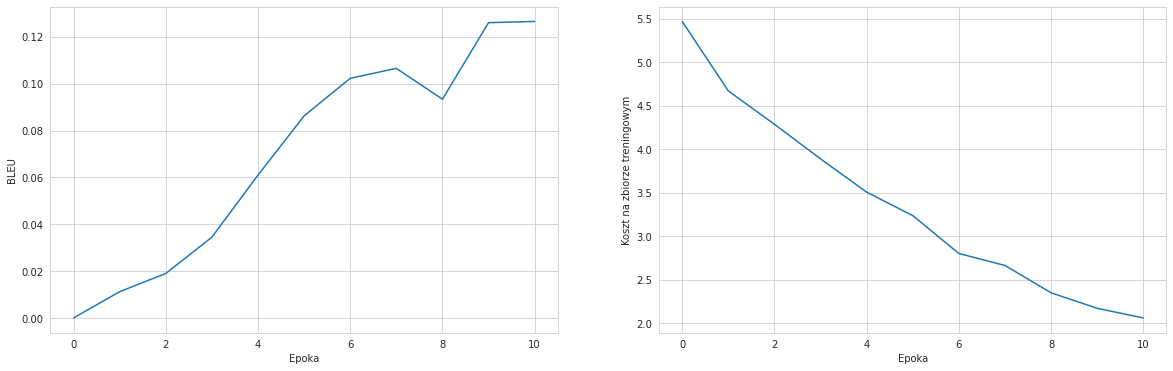

In [74]:
hidden_size = 1024
embedding_size = 512
lr = 1e-3

encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size).to(device)
decoder = DecoderRNN(output_lang.n_words, embedding_size, hidden_size).to(device)

bleus, losses = train(encoder, decoder, batch_size=512, lr=lr, epochs_num=10, clipping=0.1)
plot_results(bleus, losses)

Pokonały mnie wymiary w drugim zadaniu 😭